**İLK ÖDEVDE ASIL GÖRSELLER ÜZERİNDEKİ TRANSFORM PERFORMASNI EN YÜKSEK 0.25 VE İŞLENEN GÖRSELLER İSE 0.27 VALİDASYON DOĞRULUĞUNA ULAŞMIŞTIR
VE İMDİ SADECE İŞLENEN GÖRSELLERİN ÜZERİNDE VGG16 TRANSFORMU İLE İYİLEŞMELER YAPILACAKTIR
DİĞER DOSYADA ASIL MİMARİ BULUNUR VE BURDA VGG16 İLE DENSENET ENTEGRE EDİLEN VERSİYONDUR**

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


**ana kütüphaneler yüklendi**

**Keras kullanarak bir derin öğrenme modeli oluşturur. Amaç, göz hastalığı görüntülerini dört farklı kategoriye ayırmaktır. Bu işlem için "transfer öğrenmesi" kullanılır. Yani, daha önce genel görüntüler üzerinde eğitilmiş güçlü bir model bu özel görev için uyarlanır**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


In [2]:
from google.colab import files
uploaded = files.upload()  # eye_dataset.zip'i seç


Saving EyeDiseases_pseudo.zip to EyeDiseases_pseudo.zip


unzip işlemi ve  Kontrol için listele

In [9]:

!unzip -l "/content/EyeDiseases_pseudo.zip"

# 2. ZIP dosyasını /content içine aç
!unzip -q "/content/EyeDiseases_pseudo.zip" -d /content/islenendosya



Archive:  /content/EyeDiseases_pseudo.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
        0  2025-05-05 13:13   CNV/
        0  2025-05-05 13:13   DME/
        0  2025-05-05 13:13   DRUSEN/
        0  2025-05-05 13:13   NORMAL/
   152197  2025-05-05 13:13   DME/jet_DME-6884821-36.jpeg
   142081  2025-05-05 13:13   DME/jet_DME-4634094-51.jpeg
   176159  2025-05-05 13:13   DME/jet_DME-5091309-29.jpeg
   173965  2025-05-05 13:13   DME/jet_DME-4490546-19.jpeg
   652870  2025-05-05 13:13   DME/jet_DME-7767265-4.jpeg
   159827  2025-05-05 13:13   DME/jet_DME-3757443-96.jpeg
   164206  2025-05-05 13:13   DME/jet_DME-8130267-7.jpeg
   205655  2025-05-05 13:13   DME/jet_DME-5225805-3.jpeg
   215055  2025-05-05 13:13   DME/jet_DME-4445075-142.jpeg
    95693  2025-05-05 13:13   DME/jet_DME-8525575-30.jpeg
   161629  2025-05-05 13:13   DME/jet_DME-2388519-10.jpeg
   157096  2025-05-05 13:13   DME/jet_DME-8421260-1.jpeg
   111136  2025-05-05 13:13   DME/jet_DME-8523253

In [10]:
!ls /content/islenendosya


CNV  DME  DRUSEN  NORMAL


Listele

In [18]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [90]:
from tensorflow.keras import layers, Model, applications

def dense_block(x, num_layers=4, growth_rate=32):
    for _ in range(num_layers):
        y = layers.Conv2D(growth_rate, (3,3), padding='same')(x)
        y = layers.BatchNormalization()(y)
        y = layers.Activation('relu')(y)
        y = layers.Dropout(0.3)(y)  #Artırılmış dropout
        x = layers.Concatenate()([x, y])  #Channel-wise concatenation
    return x

#VGG16 Temel Model
base_model = applications.VGG16(weights='imagenet',
                              include_top=False,
                              input_shape=(224,224,3))
base_model.trainable = False  #İlk aşamada tabanı dondur

#Blok4 çıkışına DenseNet-style entegrasyon
x = base_model.get_layer('block4_conv3').output  # Orta seviye özellikler
x = dense_block(x, num_layers=3, growth_rate=64)

#Blok5 i özelleştirilmiş olarak kullanıldı!!
x = layers.Conv2D(512, (3,3), activation='relu', padding='same')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, kernel_regularizer='l2')(x)  #L2 regularizasyon
x = layers.BatchNormalization()(x)

outputs = layers.Dense(4, activation='softmax')(x)

model_hybrid = Model(inputs=base_model.input, outputs=outputs)

**transfer öğrenmesi ve DenseNet mimarisinden esinlenerek özelleştirilmiş bir derin öğrenme modeli oluşturur
dense_block fonksiyonu kullanılarak katmanlar arasında yoğun bağlantılar kurulur. Bu, bilgi akışını iyileştirir ve daha güçlü özellikler öğrenmeye yardımcı olur.
Regularizasyon ve normalizasyon teknikleri, modelin performansını ve kararlılığını artırmak için**

In [91]:
# Örnek veri iyileştirme
train_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: cv2.createCLAHE(clipLimit=3.0).apply(x),
    channel_shift_range=40.0,  #Renk varyasyonu
    brightness_range=[0.8,1.2],
    validation_split=0.2
)

**hannel_shift_range sınıflandırmak için kullanılan derin öğrenme modelinin eğitimi için gerekli verileri hazırlar ve iyileştirir
Veri artırımı ve ön işleme teknikleri sayesinde modelin performansının ve genelleme yeteneğinin artırılmasını sağlar**

In [92]:
#Son 4 bloğu çöz ve düşük learning rate ile eğit
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)  #Düşük LR kullnadım

 **son 4 katmanını daha düşük bir öğrenme oranıyla eğiterek, modelin göz hastalığı sınıflandırma görevine daha iyi uyum sağlamasını ve önceden öğrenilen bilgileri korumasını hedefler. Fine-tuning adı verilen bu işlem, transfer öğrenmesinin önemli bir parçasıdır ve model performansını artırmada etkilidir**

In [100]:
# Veri yükleme ve Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    '/content/split_dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/content/split_dataset/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# Early Stopping ekleme
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # İzlenecek metrik (validation loss)
    patience=3,          # İyileşme olmadan kaç epoch beklenmeli
    restore_best_weights=True  # En iyi ağırlıkları geri yükle
)



history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5),
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
    ]
)

Found 448 images belonging to 4 classes.
Found 24 images belonging to 4 classes.
Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.3732 - loss: 1.3366 

14/14 ━━━━━━━━━━━━━━━━━━━━ 259s 18s/step - accuracy: 0.3750 - loss: 1.3345 - val_accuracy: 0.5000 - val_loss: 1.2290
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.4085 - loss: 1.2738 

14/14 ━━━━━━━━━━━━━━━━━━━━ 262s 18s/step - accuracy: 0.4089 - loss: 1.2732 - val_accuracy: 0.4583 - val_loss: 1.1793
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 262s 19s/step - accuracy: 0.4623 - loss: 1.2295 - val_accuracy: 0.5833 - val_loss: 1.1866
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.4825 - loss: 1.1969 

14/14 ━━━━━━━━━━━━━━━━━━━━ 315s 18s/step - accuracy: 0.4843 - loss: 1.1956 - val_accuracy: 0.5833 - val_loss: 1.1254
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.5609 - loss: 1.1401 

14/14 ━━━━━━━━━━━━━━━━━━━━ 262s 18s/step - accuracy: 0.5605 - loss: 1.1396 - val_accuracy: 0.5833 - val_loss: 1.0972
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.5395 - loss: 1.1131 

14/14 ━━━━━━━━━━━━━━━━━━━━ 262s 18s/step - accuracy: 0.5396 - loss: 1.1126 - val_accuracy: 0.6250 - val_loss: 0.9817
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.5396 - loss: 1.1188 

14/14 ━━━━━━━━━━━━━━━━━━━━ 262s 18s/step - accuracy: 0.5419 - loss: 1.1156 - val_accuracy: 0.6250 - val_loss: 0.9719
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 255s 18s/step - accuracy: 0.5792 - loss: 1.0354 - val_accuracy: 0.6667 - val_loss: 1.0038
Epoch 9/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 262s 18s/step - accuracy: 0.5828 - loss: 1.0349 - val_accuracy: 0.6667 - val_loss: 0.9827
Epoch 10/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.5984 - loss: 1.0100 

14/14 ━━━━━━━━━━━━━━━━━━━━ 256s 18s/step - accuracy: 0.5984 - loss: 1.0104 - val_accuracy: 0.5833 - val_loss: 0.9131
Epoch 11/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 262s 19s/step - accuracy: 0.5683 - loss: 1.0291 - val_accuracy: 0.7083 - val_loss: 0.9387
Epoch 12/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.5673 - loss: 0.9887 

14/14 ━━━━━━━━━━━━━━━━━━━━ 322s 19s/step - accuracy: 0.5686 - loss: 0.9883 - val_accuracy: 0.6667 - val_loss: 0.8816
Epoch 13/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.5876 - loss: 0.9939 

14/14 ━━━━━━━━━━━━━━━━━━━━ 255s 18s/step - accuracy: 0.5881 - loss: 0.9932 - val_accuracy: 0.6667 - val_loss: 0.8772
Epoch 14/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 262s 18s/step - accuracy: 0.5850 - loss: 0.9561 - val_accuracy: 0.5833 - val_loss: 0.9188
Epoch 15/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 255s 18s/step - accuracy: 0.6629 - loss: 0.9277 - val_accuracy: 0.6667 - val_loss: 0.8824


**Veri artırma, veri jeneratörleri, model derleme, erken durdurma ve model kaydetme gibi teknikler kullanılarak modelin performansı optimize edilir** en yüksek validasyon oranı da 71

In [106]:
best_epoch = np.argmax(history.history['val_accuracy']) + 1 # Use history instead of test_generator
print(f"Best epoch: {best_epoch}")


Best epoch: 11


en iyi sonuca sahip epok'u kaydet

4/4 ━━━━━━━━━━━━━━━━━━━━ 67s 16s/step
Classification Report:
              precision    recall  f1-score   support

         CNV       0.68      0.77      0.72        30
         DME       0.70      0.53      0.60        30
      DRUSEN       0.64      0.47      0.54        30
      NORMAL       0.61      0.83      0.70        30

    accuracy                           0.65       120
   macro avg       0.65      0.65      0.64       120
weighted avg       0.65      0.65      0.64       120



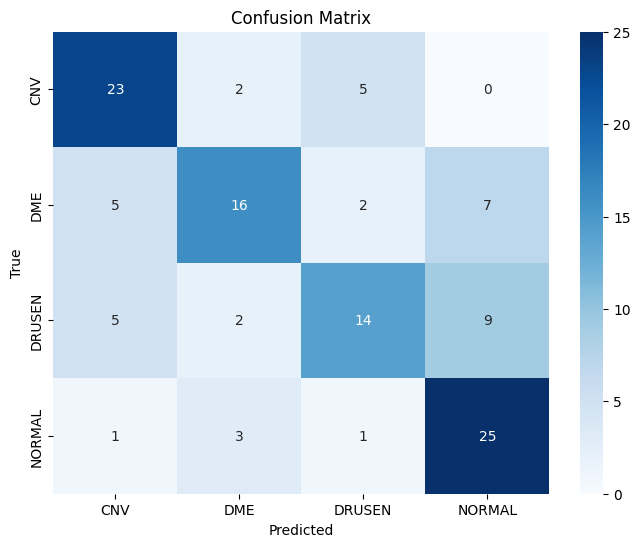

In [107]:

test_generator.reset()
pred_probs = model.predict(test_generator)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(true_classes, pred_classes, target_names=class_labels))

cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

test verisinin üzerinde sınıflandırma raporu ve karışıklık matrisi uygulandı

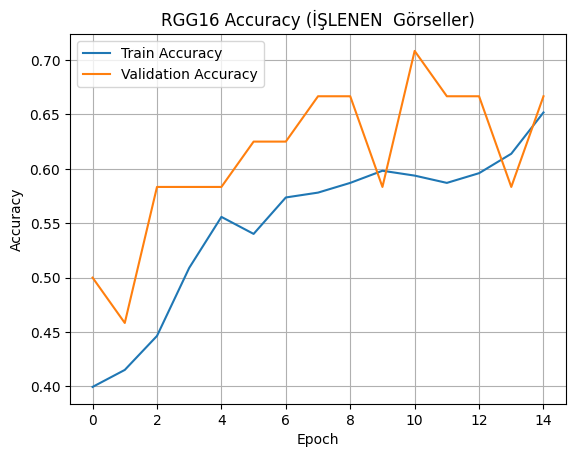

In [101]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('RGG16 Accuracy (İŞLENEN  Görseller)')
plt.legend()
plt.grid(True)
plt.show()


eğitim süreci epok sonuçlarını izlemek için plot